In [7]:
import torch
import torch.nn as nn
import torch.fft as fft
import torchvision
from torchvision.transforms import v2
import matplotlib.pyplot as plt

In [8]:
import os
import math
import numpy
from tqdm import tqdm
import cv2
import scipy

In [3]:
def load_image(path):
    transform = v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Resize((128,128))
    ])
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    image = transform(image)
    return image

In [4]:
path = os.path.join('..', 'image.jpg')
image = load_image(path)
fft_image = fft.fft2(image, dim=(-2,-1))
fft_shift = fft.fftshift(fft_image, dim=(-2,-1))
# fft_image = fft.fftshift(fft_image, dim=(-2,-1))
magnitude = torch.log(torch.abs(fft_shift)+ 1)

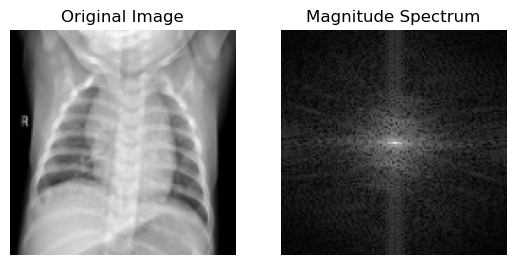

In [5]:
plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(image.permute(1,2,0), cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title('Magnitude Spectrum')
plt.imshow(magnitude.permute(1,2,0), cmap='gray')
plt.axis('off')

plt.show()

In [6]:
rows, cols = image.squeeze(0).shape
crow, ccol = rows//2, cols//2
radius = 50

mask = torch.zeros((rows, cols))
y, x = torch.meshgrid(torch.arange(0, rows), torch.arange(0, cols), indexing='ij')
mask_area = torch.sqrt((x - ccol)**2 + (y - crow)**2)

mask_h = (mask_area > radius).float()
mask_l = (mask_area <= radius).float()

In [7]:
high_filtered_fft = fft_shift * mask_h
high_filtered_image = torch.abs(fft.ifftshift(high_filtered_fft))
magnitude_high_filtered_image = torch.log(torch.abs(high_filtered_image)+ 1)

low_filtered_fft = fft_shift * mask_l
low_filtered_image = torch.abs(fft.ifftshift(low_filtered_fft))
magnitude_low_filtered_image = torch.log(torch.abs(low_filtered_image)+ 1)

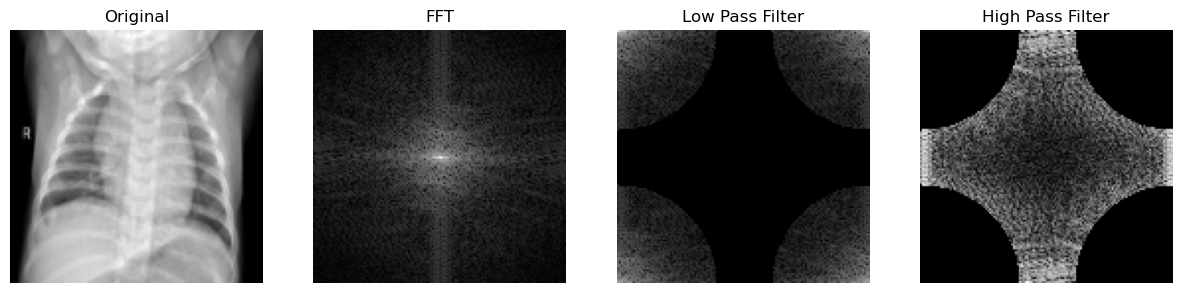

In [8]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
axes = axes.flatten()

axes[0].set_title('Original')
axes[0].imshow(image.permute(1,2,0), cmap='gray')
axes[0].axis('off')

axes[1].set_title('FFT')
axes[1].imshow(magnitude.permute(1,2,0), cmap='gray')
axes[1].axis('off')

axes[2].set_title('Low Pass Filter')
axes[2].imshow(magnitude_low_filtered_image.permute(1,2,0), cmap='gray')
axes[2].axis('off')

axes[3].set_title('High Pass Filter')
axes[3].imshow(magnitude_high_filtered_image.permute(1,2,0), cmap='gray')
axes[3].axis('off')

plt.show()

In [9]:
class FFTConvNet(nn.Module):
    def __init__(self, conv_layer, fft_filter=None):
        super().__init__()
        self.conv_layer = conv_layer

    def fft_filter_def(self, fft_x, height, width):
        cht, cwt = height//2, width//2
        mask_radius = 30
        
        mask = torch.zeros((height, width))
        fy, fx = torch.meshgrid(torch.arange(0, height, device=device), torch.arange(0, width, device=device), indexing='ij')
        mask_area = torch.sqrt((fx - cwt)**2 + (fy - cht)**2)

        if fft_filter == 'high':
            mask = (mask_area > mask_radius).float()
        elif fft_filter == 'low':
            mask = (mask_area <= mask_radius).float()
        filtered_fft = fft_x * mask
        
        return filtered_fft

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        
        # apply fft on input image
        fft_x = fft.fft2(x)
        fft_x = fft.fftshift(fft_x)

        kernel_fft = fft.fft2(self.conv_layer.weight, s=(height, width))
        kernel_fft = fft.fftshift(kernel_fft)

        # apply fft filter (low pass)
        if fft_filter is not None:
            fft_x = fft_filter_def(fft_x, height, width)
        
        # perform element wise complex multiplcation
        # fft_output = fft_x * kernel_fft

        fft_output = torch.einsum('bixy,oixy->boxy', fft_x, kernel_fft)
        
        # apply inverse fft
        fft_output = fft.ifftshift(fft_out)
        spatial_output = fft.ifft2(fft_out)
        
        # return output
        return spatial_output

In [57]:
def switch_conv_layers(model):
    for name, module in model.named_children():
        if name.startswith('inception') and isinstance(module, nn.Conv2d):
            print(name, module)
            # fft_conv = FFTConvNet(module, 'low')
            # setattr(model, name, fft_conv)
        elif isinstance(module, nn.Sequential) or isinstance(module, nn.Module):
            switch_conv_layers(module)
    return model

In [73]:
import torchvision.models as models
model = models.googlenet(weights='GoogLeNet_Weights.DEFAULT')

In [74]:
def change_layer(layer):
    fft_conv = FFTConvNet(layer, 'low')
    return fft_conv

In [75]:
# model.inception3a.branch1.conv = change_layer(model.inception3a.branch1.conv)
# model.inception3a.branch2[0].conv = change_layer(model.inception3a.branch2[0].conv)
# model.inception3a.branch2[1].conv = change_layer(model.inception3a.branch2[1].conv)
# model.inception3a.branch3[0].conv = change_layer(model.inception3a.branch3[0].conv)
# model.inception3a.branch3[1].conv = change_layer(model.inception3a.branch3[1].conv)
# model.inception3a.branch4[1].conv = change_layer(model.inception3a.branch4[1].conv)

In [76]:
for name, module in model.named_modules():
    if name.startswith('inception') and isinstance(module, nn.Conv2d):
        print(f"Modifying {name}")
        
        new_module = change_layer(module)
        parent_name, attr_name = name.rsplit(".", 1)
        parent_module = dict(model.named_modules())[parent_name]
        
        setattr(parent_module, attr_name, new_module)

Modifying inception3a.branch1.conv
Modifying inception3a.branch2.0.conv
Modifying inception3a.branch2.1.conv
Modifying inception3a.branch3.0.conv
Modifying inception3a.branch3.1.conv
Modifying inception3a.branch4.1.conv
Modifying inception3b.branch1.conv
Modifying inception3b.branch2.0.conv
Modifying inception3b.branch2.1.conv
Modifying inception3b.branch3.0.conv
Modifying inception3b.branch3.1.conv
Modifying inception3b.branch4.1.conv
Modifying inception4a.branch1.conv
Modifying inception4a.branch2.0.conv
Modifying inception4a.branch2.1.conv
Modifying inception4a.branch3.0.conv
Modifying inception4a.branch3.1.conv
Modifying inception4a.branch4.1.conv
Modifying inception4b.branch1.conv
Modifying inception4b.branch2.0.conv
Modifying inception4b.branch2.1.conv
Modifying inception4b.branch3.0.conv
Modifying inception4b.branch3.1.conv
Modifying inception4b.branch4.1.conv
Modifying inception4c.branch1.conv
Modifying inception4c.branch2.0.conv
Modifying inception4c.branch2.1.conv
Modifying i

In [77]:
model.inception3a

Inception(
  (branch1): BasicConv2d(
    (conv): FFTConvNet(
      (conv_layer): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (branch2): Sequential(
    (0): BasicConv2d(
      (conv): FFTConvNet(
        (conv_layer): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (bn): BatchNorm2d(96, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicConv2d(
      (conv): FFTConvNet(
        (conv_layer): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (bn): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (branch3): Sequential(
    (0): BasicConv2d(
      (conv): FFTConvNet(
        (conv_layer): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (bn): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, 